In [1]:
import os
localfs_path = os.environ.get('SCRATCH_LOCAL') + '/'

os.environ['_JAVA_OPTIONS'] = f'-Djava.io.tmpdir={localfs_path}'

import hail as hl

hl.init(
    tmp_dir=(localfs_path+'tmp_hail'),
    spark_conf={'spark.driver.memory': '30G', 'spark.executor.memory': '10G'}, # I don't know what should be here
    default_reference='GRCh38'
) 

Picked up _JAVA_OPTIONS: -Djava.io.tmpdir=/localfs/4736297/
Picked up _JAVA_OPTIONS: -Djava.io.tmpdir=/localfs/4736297/


23/09/12 15:51:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.2
SparkUI available at http://ac0520:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.113-cf32652c5077
LOGGING: writing to /net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-gts/preprocessing/oligogenic-model/hail-20230912-1551-0.2.113-cf32652c5077.log


In [2]:
from bokeh.io import show, output_notebook, export_png

from bokeh.layouts import gridplot
output_notebook()
import numpy as np

import bokeh.palettes
from bokeh.models import CategoricalColorMapper

Loading BokehJS ...

In [8]:
from oligogenic_model import model_assignment

In [3]:
%load_ext autoreload
%autoreload 2

### load oligogenic scores results (first just from the classifier)

In [75]:
results = hl.read_matrix_table(localfs_path+'gts_sport_13stand_per_gene.mt') #this is from 6-oligogenic-model

genes = ['CHADL', 'DRD2', 'MAOA', 'PCDH10', 'HTR2A', 'SLITRK5', 'SORCS3', 'KCNQ5', 'CDH9', 'CHD8']

group, sport, model_sum, model_weits = model_assignment(results, genes)

In [76]:
# now standardise the scores:

model_o = (model_sum[0] - model_sum[0].mean())/(model_sum[0].std())

In [77]:
prs = hl.import_table(
    'prs-score-rm-altloci.tsv'
)

prs = prs.transmute(s = prs['sample'])
prs = prs.key_by(prs.s)

2023-09-12 16:33:04.180 Hail: INFO: Reading table without type imputation
  Loading field 'sample' as type str (not specified)
  Loading field 'model' as type str (not specified)
  Loading field 'p-value' as type str (not specified)
  Loading field 'prs_score' as type str (not specified)
  Loading field 'genotyping_alleles_count' as type str (not specified)
  Loading field 'imputing_alleles_count' as type str (not specified)
  Loading field 'af_alleles_count' as type str (not specified)
  Loading field 'missing_alleles_count' as type str (not specified)


In [78]:
prs = prs.filter(prs.model == 'model-'+str(5)+'.yml-result.json')

In [80]:
results = results.annotate_cols(prs_ass = prs[results.s]['prs_score'])

results = results.filter_cols(hl.is_defined(results.prs_ass))

In [81]:
results = results.annotate_cols(
        skat_pheno = hl.if_else(
            results.group == 'GTS',
            hl.if_else(
                results.phenotypes.phenotype == 'GTS',
                'YES',
                'NO'),
            'NO'
        )
    )

In [82]:
results = results.filter_rows(
    hl.literal(genes).contains(results.nearest_genes_20kb)
)

In [83]:
results = results.annotate_cols(
    gts = hl.int(results.skat_pheno == 'YES')
)

In [84]:
group2 = np.array(results.gts.collect())

In [93]:
prs_assignment = np.array(hl.float(results['prs_ass']).collect())

prs_assignment = (prs_assignment - prs_assignment.mean())/(prs_assignment.std())

In [98]:
# get a combined score

results = hl.read_matrix_table(localfs_path+'gts_sport_13stand_per_gene.mt') #this is from 6-oligogenic-model
genes = ['CHADL', 'DRD2', 'MAOA', 'PCDH10', 'HTR2A', 'SLITRK5', 'SORCS3', 'KCNQ5', 'CDH9', 'CHD8']


results = results.annotate_cols(prs_ass = prs[results.s]['prs_score'])
results = results.filter_cols(hl.is_defined(results.prs_ass))

group, sport, model_sum, model_weits = model_assignment(results, genes)

In [99]:
model_o = (model_sum[0] - model_sum[0].mean())/(model_sum[0].std())

In [100]:
prs_assignment = np.array(hl.float(results['prs_ass']).collect())
prs_assignment = (prs_assignment - prs_assignment.mean())/(prs_assignment.std())

In [104]:
model_both = model_o + prs_assignment

In [94]:
from bokeh.models import Label, LabelSet

colors = bokeh.palettes.Category20[16]

y = np.linspace(0,1)
x = np.linspace(0,1,100)

from bokeh.plotting import figure, output_notebook, show

output_notebook

p = figure(plot_width=800, plot_height=800)
      
start = np.min(model_o)-1
stop = np.max(model_o)+1

false_pos1 = []
true_pos1 = []

for x in np.linspace(start,stop,20000):
    false_pos1.append(np.sum((model_o > x)[group == 0])/157)
    true_pos1.append(np.sum((model_o > x)[group == 1])/46)

p.line(false_pos1, true_pos1, line_width=4, line_color='#4A7A89')

start = np.min(prs_assignment)-1
stop = np.max(prs_assignment)+1

false_pos = []
true_pos = []

for x in np.linspace(start,stop,20000):
    false_pos.append(np.sum((prs_assignment > x)[group2 == 0])/157)
    true_pos.append(np.sum((prs_assignment > x)[group2 == 1])/46)

p.line(false_pos, true_pos, line_width=4, line_color='#D5AFA5')

start = np.min(prs_assignment)-1
stop = np.max(prs_assignment)+1

false_pos = []
true_pos = []

for x in np.linspace(start,stop,20000):
    false_pos.append(np.sum((prs_assignment > x)[group2 == 0])/157)
    true_pos.append(np.sum((prs_assignment > x)[group2 == 1])/46)

p.line(false_pos, true_pos, line_width=4, line_color='#D5AFA5')


p.line([0, 0.5, 1], [0, 0.5, 1], line_color='grey')

p.xaxis.axis_label = 'false positives'
p.yaxis.axis_label = 'true positives'

p.xaxis.axis_label_text_font_size = "15pt"
p.xaxis.major_label_text_font_size = "15pt"
p.yaxis.axis_label_text_font_size = "15pt"
p.yaxis.major_label_text_font_size = "15pt"


In [107]:
start = np.min(model_both)-1
stop = np.max(model_both)+1

false_pos = []
true_pos = []

for x in np.linspace(start,stop,20000):
    false_pos.append(np.sum((model_both > x)[group2 == 0])/157)
    true_pos.append(np.sum((model_both > x)[group2 == 1])/46)

p.line(false_pos, true_pos, line_width=4, line_color='#85A5AF')

GlyphRenderer(id='3414', ...)

In [108]:
show(p)

In [ ]:
def make_score_box(prs, model_thresh):
    
    sns.set(rc={'figure.figsize':(8,8)})
    sns.set(font_scale=1.7)
    sns.set_style(style='white')

    ass = prs.filter(prs.model == 'model-'+str(model_thresh)+'.yml-result.json')
    all_ass = np.array((ass.prs_score).collect())
    
    groups = ['GTS',
              'Polish sportsmen',
              'healthy family members',
              'non-GTS TDs',
              'severe GTS']

    palette = {
            'Polish sportsmen':sns.diverging_palette(220, 20)[0],
            'healthy family members':sns.diverging_palette(220, 20)[1],
            'non-GTS TDs':sns.diverging_palette(220, 20)[2],
            'GTS':sns.diverging_palette(220, 20)[3],
            'severe GTS':sns.diverging_palette(220, 20)[4],
        }
    
    all_samples = np.array(ass.group.collect())
    
    sns.boxplot(
        x=all_samples,
        y=all_ass,
        hue=all_samples,
        dodge=False,
        palette=palette,
        order = [
            'Polish sportsmen',
            'healthy family members',
            'non-GTS TDs',
            'GTS',
            'severe GTS'
        ]
    )
    
    
    # Plot formatting
    plt.title('PRS score per group')
    plt.xlabel('group')
    plt.xticks(rotation=45)
    
    plt.ylabel('score value')
    plt.legend([],[], frameon=False)
    plt.savefig("box.png")

    return(plt)

2023-08-06 07:56:16.611 Hail: INFO: Ordering unsorted dataset with network shuffle
2023-08-06 07:56:17.301 Hail: INFO: Ordering unsorted dataset with network shuffle
2023-08-06 07:56:17.563 Hail: INFO: Ordering unsorted dataset with network shuffle


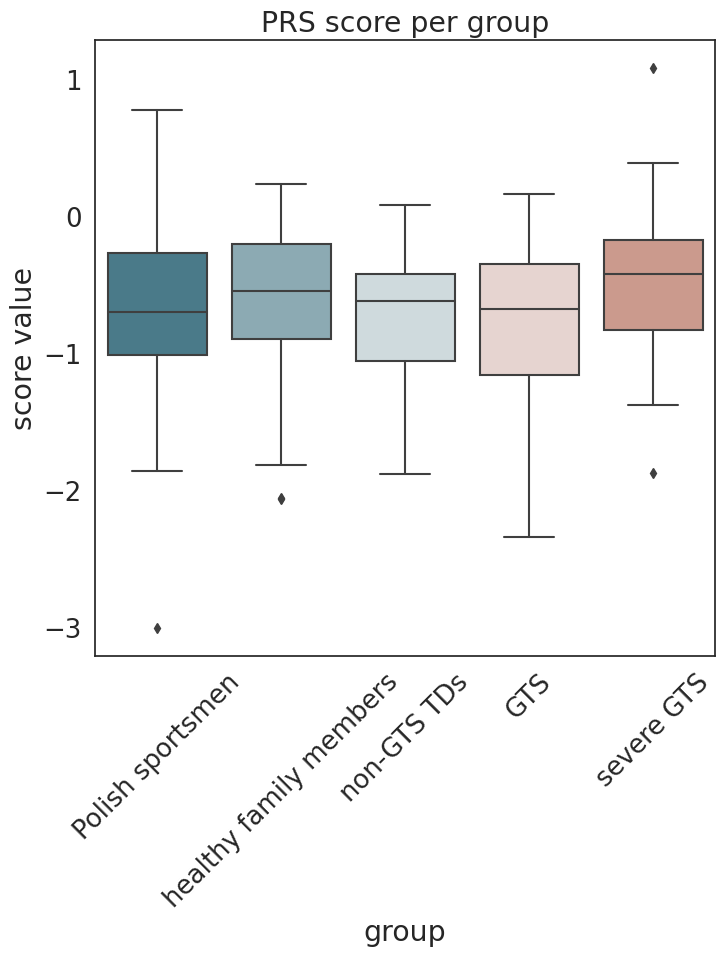

In [239]:
p = make_score_box(prs, 5)

In [199]:
def make_score_hist(prs, model_thresh):
    
    sns.set(rc={'figure.figsize':(12,8)})
    sns.set(font_scale=1.2)
    sns.set_style(style='white')


    ass = prs.filter(prs.model == 'model-'+str(model_thresh)+'.yml-result.json')
    all_ass = np.array((ass.prs_score).collect())
    
    groups = [
        'GTS',
        'Polish sportsmen',
        'healthy family members',
        'non-GTS TDs',
        'severe GTS'
    ]

    palette = {
        'Polish sportsmen':sns.diverging_palette(220, 20)[0],
        'healthy family members':sns.diverging_palette(220, 20)[1],
        'non-GTS TDs':sns.diverging_palette(220, 20)[2],
        'GTS':sns.diverging_palette(220, 20)[3],
        'severe GTS':sns.diverging_palette(220, 20)[4]
    }

    all_samples = np.array(ass.group.collect())

    for group in groups:
   
        subset = all_ass[np.where(all_samples == group)]
       
        # Draw the density plot
        sns.histplot(subset, kde = True,
                     label = group,
                     stat="percent",
                     kde_kws=dict(cut=3),
                     alpha=.3,
                     binrange=[-5,5],
                     binwidth=0.3,
                     color=palette[group]
                    )
    
    
    # Plot formatting
    plt.legend(prop={'size': 16}, title = 'PRS histogram')
    plt.title('PRS histogram')
    plt.xlabel('group')
    plt.ylabel('PRS score')
    plt.savefig("hists.png")
    
    
    return(plt)

2023-08-05 20:03:39.736 Hail: INFO: Ordering unsorted dataset with network shuffle
2023-08-05 20:03:40.456 Hail: INFO: Ordering unsorted dataset with network shuffle
2023-08-05 20:03:40.737 Hail: INFO: Ordering unsorted dataset with network shuffle


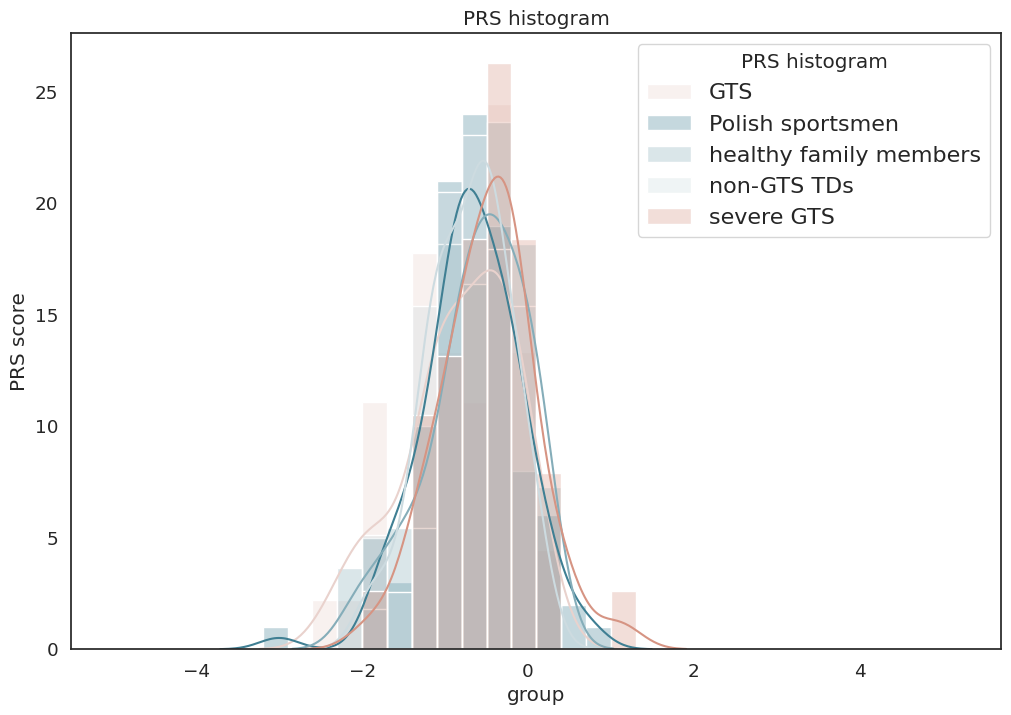

In [200]:
p2 = make_score_hist(prs, 5)

In [201]:
from scipy.stats import f_oneway
from scipy import stats

all_ass = np.array(prs.prs_score.collect())
all_samples = np.array(prs.group.collect())
    
subsets = []

groups = [
        'GTS',
        'Polish sportsmen',
        'healthy family members',
        'non-GTS TDs',
        'severe GTS'
    ]

for group in groups:
    subsets.append(all_ass[np.where(all_samples == group)]) 

f_oneway(*subsets)

print(groups[0], 'vs', groups[1], stats.ttest_ind(subsets[0], subsets[1]))

print(groups[0], 'vs', groups[2], stats.ttest_ind(subsets[0], subsets[2]))

print(groups[4], 'vs', groups[2], stats.ttest_ind(subsets[4], subsets[2]))

print(groups[0], 'vs', groups[4], stats.ttest_ind(subsets[0], subsets[4]))

print(groups[2], 'vs', groups[3], stats.ttest_ind(subsets[2], subsets[3]))

print(groups[0], 'vs', groups[3], stats.ttest_ind(subsets[0], subsets[3]))

print(groups[3], 'vs', groups[4], stats.ttest_ind(subsets[3], subsets[4]))

print(groups[3], 'vs', groups[1], stats.ttest_ind(subsets[3], subsets[1]))

print(groups[1], 'vs', groups[2], stats.ttest_ind(subsets[1], subsets[2]))

print(groups[4], 'vs', groups[1], stats.ttest_ind(subsets[4], subsets[1]))

#https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00

#gwas validation + PRS

2023-08-05 20:03:42.372 Hail: INFO: Ordering unsorted dataset with network shuffle
2023-08-05 20:03:43.147 Hail: INFO: Ordering unsorted dataset with network shuffle
2023-08-05 20:03:43.417 Hail: INFO: Ordering unsorted dataset with network shuffle


GTS vs Polish sportsmen Ttest_indResult(statistic=-0.8824498736477226, pvalue=0.3779004196647876)
GTS vs healthy family members Ttest_indResult(statistic=-2.104566240054376, pvalue=0.03595558459375528)
severe GTS vs healthy family members Ttest_indResult(statistic=0.014667992111280226, pvalue=0.9883049610540241)
GTS vs severe GTS Ttest_indResult(statistic=-1.9044638355725105, pvalue=0.057719156891721614)
healthy family members vs non-GTS TDs Ttest_indResult(statistic=2.018478705466984, pvalue=0.04425475776000441)
GTS vs non-GTS TDs Ttest_indResult(statistic=-0.14698783212566746, pvalue=0.8832303076823713)
non-GTS TDs vs severe GTS Ttest_indResult(statistic=-1.867382075195784, pvalue=0.06280417168439524)
non-GTS TDs vs Polish sportsmen Ttest_indResult(statistic=-0.7035214267539494, pvalue=0.4820264197052794)
Polish sportsmen vs healthy family members Ttest_indResult(statistic=-1.5752491034589733, pvalue=0.11571070693217539)
severe GTS vs Polish sportsmen Ttest_indResult(statistic=1.3935